In [106]:
#Librerias
import re
from pathlib import Path
from dataclasses import dataclass
import pandas as pd
import numpy as np
from typing import List, Dict
import requests
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

# ---------------------------
# Config
# ---------------------------
folder = Path(r"C:\Users\MI PC\Desktop\Challenge Data Science\CSV")

# Incluye .xlsx y .xls si existen
files = sorted(list(folder.glob("*.xlsx")) + list(folder.glob("*.xls")))
print(f"Encontrados {len(files)} archivos.")

# ---------------------------
# Helpers
# ---------------------------
def normalize_cols(cols: pd.Index) -> pd.Index:
    return (
        pd.Index(cols)
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w_]", "", regex=True)  # quita acentos y signos
        .str.upper()
    )

def is_effectively_empty(df: pd.DataFrame) -> bool:
    if df.size == 0:
        return True
    df2 = df.dropna(how="all")
    if df2.empty:
        return True
    obj_cols = df2.select_dtypes(include="object").columns
    if len(obj_cols) > 0:
        df2.loc[:, obj_cols] = df2.loc[:, obj_cols].apply(lambda s: s.astype(str).str.strip())
        df2.replace("", np.nan, inplace=True)
    return df2.dropna(how="all").empty

def has_any_meaningful_row(df: pd.DataFrame) -> bool:
    df2 = df.copy()
    obj_cols = df2.select_dtypes(include="object").columns
    if len(obj_cols) > 0:
        df2.loc[:, obj_cols] = df2.loc[:, obj_cols].apply(lambda s: s.astype(str).str.strip())
        df2.replace("", np.nan, inplace=True)
    return (df2.notna().sum(axis=1) >= 2).any()


# ---------------------------
# Ingesta de TODAS las hojas de TODOS los archivos
# ---------------------------
dfs = []
for f in files:
    try:
        book = pd.read_excel(f, sheet_name=None, engine=None)  # autodetecta engine
        if not book:
            print(f"[SKIP] {f.name}: libro vacío o ilegible.")
            continue

        for sh, df_sh in book.items():
            try:
                if is_effectively_empty(df_sh) or not has_any_meaningful_row(df_sh):
                    print(f"[SKIP] {f.name} | '{sh}': hoja vacía o sin datos útiles.")
                    continue

                # Normaliza columnas
                df_sh.columns = normalize_cols(df_sh.columns)

                # Sucursal desde el nombre del archivo (sin extensión)
                df_sh["SUCURSAL"] = f.stem

                # Trazabilidad adicional
                df_sh["ARCHIVO_ORIGEN"] = f.name
                df_sh["HOJA_ORIGEN"] = str(sh)

                # Parseo opcional de fecha
                for candidate in ("FECHA", "DATE"):
                    if candidate in df_sh.columns:
                        df_sh[candidate] = pd.to_datetime(df_sh[candidate], errors="coerce")
                        break

                dfs.append(df_sh)

            except Exception as e:
                print(f"[WARN] Falló hoja '{sh}' en {f.name}: {e}")
    except Exception as e:
        print(f"[ERROR] No se pudo abrir {f.name}: {e}")

if not dfs:
    raise RuntimeError("No se leyó ninguna hoja. Revisa rutas/formatos.")

Data_raw = pd.concat(dfs, ignore_index=True, sort=False)
print("Shape consolidado:", Data_raw.shape)



Encontrados 4 archivos.
Shape consolidado: (848032, 26)


In [78]:
# Verificación de carga correcta de todos los files
Data_raw["FILENAME"] = Data_raw["ARCHIVO_ORIGEN"].astype(str) + " | " + Data_raw["HOJA_ORIGEN"].astype(str)

# Agrupar y contar filas por cada archivo+hoja
gb = (
    Data_raw.groupby("FILENAME")
            .size()  # cuenta filas
            .reset_index(name="N_FILAS")
            .sort_values("FILENAME", ascending=False)
)

print(gb.head(30))   # muestra las 20 combinaciones con más filas

#---------------------------------------------------------------------

# Vista rápida 
try:
    display(Data_raw.head(2))
except Exception:
    print(Data_raw.head(2))

# Copia de trabajo
temp = Data_raw.copy()




                              FILENAME  N_FILAS
27  Ventas VicenteLopez.xlsx | 2024-07    22029
26  Ventas VicenteLopez.xlsx | 2024-06    20493
25  Ventas VicenteLopez.xlsx | 2024-05    23863
24  Ventas VicenteLopez.xlsx | 2024-04    23730
23  Ventas VicenteLopez.xlsx | 2024-03    23668
22  Ventas VicenteLopez.xlsx | 2024-02    21572
21  Ventas VicenteLopez.xlsx | 2024-01    25007
20    Ventas LaHorqueta.xlsx | 2024-07    34116
19    Ventas LaHorqueta.xlsx | 2024-06    33711
18    Ventas LaHorqueta.xlsx | 2024-05    38286
17    Ventas LaHorqueta.xlsx | 2024-04    36965
16    Ventas LaHorqueta.xlsx | 2024-03    36729
15    Ventas LaHorqueta.xlsx | 2024-02    33164
14    Ventas LaHorqueta.xlsx | 2024-01    33394
13      Ventas CiudadSF.xlsx | 2024-07    29064
12      Ventas CiudadSF.xlsx | 2024-06    24726
11      Ventas CiudadSF.xlsx | 2024-05    27628
10      Ventas CiudadSF.xlsx | 2024-04    28166
9       Ventas CiudadSF.xlsx | 2024-03    30067
8       Ventas CiudadSF.xlsx | 2024-02  

,FECHA,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,SUCURSAL,ARCHIVO_ORIGEN,HOJA_ORIGEN,FILENAME
0,2024-01-05 10:58:49,30266,3,63,Alvisa,1,Oscar Datino,10000,Nafta Super,10000,...,0.98,"21,601.00","3,246,100.00","855,821.00","414,800.00",0.92,Ventas Alvisa,Ventas Alvisa.xlsx,2024-01,Ventas Alvisa.xlsx | 2024-01
1,2024-01-01 02:54:37,29519,3,63,Alvisa,1,Oscar Datino,19000000,Hielo Rolito x 4Kg,2820000,...,"300,000.00","1,950,000.00","2,450,200.00","155,702.00","398,200.00","35,500.00",Ventas Alvisa,Ventas Alvisa.xlsx,2024-01,Ventas Alvisa.xlsx | 2024-01


In [98]:
# --- helpers --------------------------
_money_pat = re.compile(r"[^\d,.\-]")  # quita símbolos no numéricos (deja - . , y dígitos)

def to_numeric_tolerant(s: pd.Series) -> pd.Series:
    """
    Convierte a número tolerando formatos tipo '1.234,56' o '$ 1,234.56'.
    """
    if s.dtype.kind in "ifb":
        return pd.to_numeric(s, errors="coerce")
    s2 = (
        s.astype(str)
         .str.strip()
         .str.replace(_money_pat, "", regex=True)
         .replace({"": np.nan})
    )
    def _coerce_one(x: str):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return np.nan
        x = str(x)
        if "," in x and "." in x:
            if x.rfind(",") > x.rfind("."):
                x = x.replace(".", "").replace(",", ".")
            else:
                x = x.replace(",", "")
        elif "," in x and "." not in x:
            x = x.replace(".", "").replace(",", ".")
        else:
            x = x.replace(",", "")
        try:
            return float(x)
        except Exception:
            return np.nan
    return s2.map(_coerce_one)

def to_datetime_safe(s: pd.Series) -> pd.Series:
    if s.dtype.kind == "M":
        return s
    return pd.to_datetime(s, errors="coerce")

# --- nuevo: normalización a float64 de MONTO*/COSTO* --------------------------
def cast_monto_costo_to_float64(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    cols_target = [c for c in df2.columns if str(c).strip().upper().startswith(("MONTO", "COSTO","VALOR","VENTA","CANTIDAD"))]
    for col in cols_target:
        df2[col] = to_numeric_tolerant(df2[col]).astype("float64")
    print(f"[cast] Columnas convertidas a float64: {len(cols_target)}")
    return df2

# --- auditor --------------------------
def audit_basico(
    df: pd.DataFrame,
    fecha_col: str = "FECHA",            # <- por tu ingesta en MAYÚSCULAS
    suc_col: str = "SUCURSAL",           # <- idem
    montos_cols: List[str] = (
        "VALOR_ARTICULO",
        "COSTO_ARTICULO",
        "VENTA_BRUTA",
        "MONTO_IMPUESTOS_INTERNOS",
        "MONTO_IVA",
        "CANTIDAD_VENDIDA",
    ),
    dup_key_cols: List[str] = (
        "SUCURSAL",
        "FECHA",
        "NUMERO_TICKET",
        "ID_ARTICULO",
        "CANTIDAD_VENDIDA",
        "VALOR_ARTICULO",
        "COSTO_ARTICULO",
    ),
    fecha_min: str = "2022-01-01",
    fecha_max: str = "2025-12-31",
    max_dups_preview: int = 5000,        # limitar detalle para no explotar RAM
) -> Dict[str, object]:
    rep: Dict[str, object] = {}

    nfilas = len(df)
    rep["filas_totales"] = int(nfilas)

    # 1) NULOS (por columna)
    rep["nulos_por_col"] = df.isna().sum().sort_values(ascending=False)

    # 2) FECHAS
    if fecha_col in df.columns:
        fechas = to_datetime_safe(df[fecha_col])
        rep["fecha_tipo_ok"] = bool(fechas.dtype.kind == "M")
        rep["fecha_nat"] = int(fechas.isna().sum())
        rep["fecha_nat_pct"] = 0.0 if nfilas == 0 else float(100 * rep["fecha_nat"] / nfilas)
        rep["fecha_min_en_data"] = fechas.min()
        rep["fecha_max_en_data"] = fechas.max()
        fmin = pd.Timestamp(fecha_min)
        fmax = pd.Timestamp(fecha_max)
        rep["fecha_fuera_rango"] = int(((fechas < fmin) | (fechas > fmax)).sum())
    else:
        rep["fecha_tipo_ok"] = False
        rep["fecha_nat"] = nfilas
        rep["fecha_nat_pct"] = 100.0
        rep["fecha_min_en_data"] = pd.NaT
        rep["fecha_max_en_data"] = pd.NaT
        rep["fecha_fuera_rango"] = 0
        fechas = pd.Series(pd.NaT, index=df.index, name="__FECHA_DT")

    # 2b) MONTOS NO NUMÉRICOS (tras coerción tolerante)
    no_numericos = {}
    for col in montos_cols:
        if col in df.columns:
            coerced = to_numeric_tolerant(df[col])
            mal = ((df[col].notna()) & (coerced.isna())).sum()
            no_numericos[col] = int(mal)
    rep["montos_no_numericos"] = (
        pd.Series(no_numericos).sort_values(ascending=False)
        if no_numericos else pd.Series(dtype=int)
    )

    # 3) DUPLICADOS
    dup_cols_existentes = [c for c in dup_key_cols if c in df.columns]
    use_temp_date = False
    df_ = df

    if fecha_col in dup_cols_existentes:
        if fecha_col in df.columns and df[fecha_col].dtype.kind != "M":
            df_ = df.copy()
            df_["__FECHA_DT"] = fechas
            dup_cols_existentes = [("__FECHA_DT" if c == fecha_col else c) for c in dup_cols_existentes]
            use_temp_date = True

    if dup_cols_existentes:
        mask_dups = df_.duplicated(subset=dup_cols_existentes, keep=False)
        dups_df = df_.loc[mask_dups].sort_values(dup_cols_existentes)
        if suc_col not in dups_df.columns and suc_col in df.columns:
            dups_df = dups_df.assign(**{suc_col: df[suc_col]})
        if suc_col in dups_df.columns:
            dups_por_suc = dups_df.groupby(suc_col, dropna=False).size().sort_values(ascending=False)
        else:
            dups_por_suc = pd.Series(dtype=int)

        rep["duplicados_total"] = int(mask_dups.sum())
        rep["duplicados_por_sucursal"] = dups_por_suc

        if max_dups_preview is not None and len(dups_df) > max_dups_preview:
            rep["duplicados_detalle"] = dups_df.head(max_dups_preview).copy()
            rep["duplicados_detalle_truncado"] = True
        else:
            rep["duplicados_detalle"] = dups_df
            rep["duplicados_detalle_truncado"] = False

        if use_temp_date and "__FECHA_DT" in rep["duplicados_detalle"].columns:
            rep["duplicados_detalle"].drop(columns=["__FECHA_DT"], inplace=True, errors="ignore")
    else:
        rep["duplicados_total"] = 0
        rep["duplicados_por_sucursal"] = pd.Series(dtype=int)
        rep["duplicados_detalle"] = pd.DataFrame()
        rep["duplicados_detalle_truncado"] = False

    return rep

# =======================
# USO
# =======================
# 1) Normaliza a float64 las columnas MONTO*/COSTO*
temp_norm = cast_monto_costo_to_float64(temp)

# 2) Pasa el df normalizado a la auditoría
reporte = audit_basico(temp_norm)

print("Filas totales:", reporte.get("filas_totales"))
print("\n--- Nulos por columna (top 15) ---")
print(reporte.get("nulos_por_col").head(15))

print("\n--- FECHA ---")
print("¿dtype datetime?:", reporte.get("fecha_tipo_ok"))
print("NaT:", reporte.get("fecha_nat"), f"({reporte.get('fecha_nat_pct'):.2f}%)")
print("Mín/Max en datos:", reporte.get("fecha_min_en_data"), "/", reporte.get("fecha_max_en_data"))
print("Fuera de rango esperado:", reporte.get("fecha_fuera_rango"))

print("\n--- Montos NO numéricos ---")
print(reporte.get("montos_no_numericos"))

print("\n--- Duplicados ---")
print("Total duplicados:", reporte.get("duplicados_total"))



[cast] Columnas convertidas a float64: 7
Filas totales: 848032

--- Nulos por columna (top 15) ---
FECHA                       1
CANTIDAD_TICKET             1
COSTO_ARTICULO              1
MONTO_IVA                   1
MONTO_IMPUESTOS_INTERNOS    1
VENTA_BRUTA                 1
VALOR_ARTICULO              1
CANTIDAD_VENDIDA            1
DESC_RUBRO                  0
HOJA_ORIGEN                 0
ARCHIVO_ORIGEN              0
SUCURSAL                    0
DESC_SUBRUBRO               0
SUBRUBRO                    0
RUBRO                       0
dtype: int64

--- FECHA ---
¿dtype datetime?: True
NaT: 1 (0.00%)
Mín/Max en datos: 2024-01-01 00:30:23 / 2024-07-31 23:59:41
Fuera de rango esperado: 0

--- Montos NO numéricos ---
VALOR_ARTICULO              0
COSTO_ARTICULO              0
VENTA_BRUTA                 0
MONTO_IMPUESTOS_INTERNOS    0
MONTO_IVA                   0
CANTIDAD_VENDIDA            0
dtype: int64

--- Duplicados ---
Total duplicados: 12


In [89]:
# --- Filas con FECHA nula o inválida ---
filas_fecha_nula = temp[temp["FECHA"].isna()]
print("Filas con FECHA nula:", len(filas_fecha_nula))
display(filas_fecha_nula.head(10))

# --- Filas con montos no numéricos ---
cols_montos = ["VALOR_ARTICULO", "COSTO_ARTICULO",
               "VENTA_BRUTA", "MONTO_IMPUESTOS_INTERNOS",
               "MONTO_IVA", "CANTIDAD_VENDIDA"]

filas_montos_anormales = pd.DataFrame()
for col in cols_montos:
    if col in temp.columns:
        coerced = pd.to_numeric(temp[col].astype(str)
                                .str.replace(",", "")
                                .str.replace("$", "")
                                .str.strip(),
                                errors="coerce")
        mask = (temp[col].notna()) & (coerced.isna())
        if mask.any():
            filas_montos_anormales = pd.concat([filas_montos_anormales, temp[mask]])

print("Filas con montos no numéricos:", len(filas_montos_anormales))
display(filas_montos_anormales.head(10))

# --- Filas duplicadas detectadas ---
# Usa las mismas claves que tu función audit_basico
dup_keys = ["SUCURSAL", "FECHA", "NUMERO_TICKET", "ID_ARTICULO",
            "CANTIDAD_VENDIDA", "VALOR_ARTICULO", "COSTO_ARTICULO"]
dup_keys_exist = [c for c in dup_keys if c in temp.columns]
filas_duplicadas = temp[temp.duplicated(subset=dup_keys_exist, keep=False)]
print("Filas duplicadas:", len(filas_duplicadas))
display(filas_duplicadas.sort_values(dup_keys_exist).head(20))


Filas con FECHA nula: 1


,FECHA,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,SUCURSAL,ARCHIVO_ORIGEN,HOJA_ORIGEN,FILENAME
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02


Filas con montos no numéricos: 6


,FECHA,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,SUCURSAL,ARCHIVO_ORIGEN,HOJA_ORIGEN,FILENAME
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02
62015,NaT,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,Ventas Alvisa,Ventas Alvisa.xlsx,2024-02,Ventas Alvisa.xlsx | 2024-02


Filas duplicadas: 12


,FECHA,NUMERO_TICKET,CANTIDAD_TICKET,ID_SUCURSAL,DESCRIP_SUCURSAL,ID_ZONA_SUPERVISION,DESC_ZONA_SUPERVICION,ID_ARTICULO,DESC_ARTICULO,FAMILIA,...,CANTIDAD_VENDIDA,VALOR_ARTICULO,VENTA_BRUTA,MONTO_IMPUESTOS_INTERNOS,MONTO_IVA,COSTO_ARTICULO,SUCURSAL,ARCHIVO_ORIGEN,HOJA_ORIGEN,FILENAME
301652,2024-02-29 23:58:09,30646,3,88,Ciudad de Sta Fe,3,Miguel Molachino,3050000,Bardahl Inyector Cleaner x 250cc,2820000,...,"10,000.00","95,000.00","830,000.00","244,426.00","101,700.00","50,400.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-02,Ventas CiudadSF.xlsx | 2024-02
301653,2024-02-29 23:58:09,30646,3,88,Ciudad de Sta Fe,3,Miguel Molachino,3050000,Bardahl Inyector Cleaner x 250cc,2820000,...,"10,000.00","95,000.00","830,000.00","244,426.00","101,700.00","50,400.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-02,Ventas CiudadSF.xlsx | 2024-02
331719,2024-03-31 23:52:29,27836,3,88,Ciudad de Sta Fe,3,Miguel Molachino,186160000,Lubrax MP 40 x 205L ( Suelto ),20000,...,"30,000.00","222,000.00","813,000.00","140,005.00","116,800.00","42,500.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-03,Ventas CiudadSF.xlsx | 2024-03
331720,2024-03-31 23:52:29,27836,3,88,Ciudad de Sta Fe,3,Miguel Molachino,186160000,Lubrax MP 40 x 205L ( Suelto ),20000,...,"30,000.00","222,000.00","813,000.00","140,005.00","116,800.00","42,500.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-03,Ventas CiudadSF.xlsx | 2024-03
359885,2024-04-30 23:57:09,132166,26,88,Ciudad de Sta Fe,3,Miguel Molachino,207030000,Cofler l/almend Chocolate x 28g,50000,...,"10,000.00","16,000.00","3,072,500.00","209,590.00","471,300.00",0.72,Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-04,Ventas CiudadSF.xlsx | 2024-04
359886,2024-04-30 23:57:09,132166,26,88,Ciudad de Sta Fe,3,Miguel Molachino,207030000,Cofler l/almend Chocolate x 28g,50000,...,"10,000.00","16,000.00","3,072,500.00","209,590.00","471,300.00",0.72,Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-04,Ventas CiudadSF.xlsx | 2024-04
387513,2024-05-31 23:59:15,48300,1,88,Ciudad de Sta Fe,3,Miguel Molachino,206480000,Cofler Air Leche 100g,50000,...,"10,000.00","70,000.00","386,000.00","24,690.00","62,800.00","31,460.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-05,Ventas CiudadSF.xlsx | 2024-05
387514,2024-05-31 23:59:15,48300,1,88,Ciudad de Sta Fe,3,Miguel Molachino,206480000,Cofler Air Leche 100g,50000,...,"10,000.00","70,000.00","386,000.00","24,690.00","62,800.00","31,460.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-05,Ventas CiudadSF.xlsx | 2024-05
412239,2024-06-30 23:59:19,142015,6,88,Ciudad de Sta Fe,3,Miguel Molachino,206310000,Bombon Felfort Botell Whisky,50000,...,"10,000.00","24,000.00","650,500.00","36,455.00","37,100.00","10,800.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-06,Ventas CiudadSF.xlsx | 2024-06
412240,2024-06-30 23:59:19,142015,6,88,Ciudad de Sta Fe,3,Miguel Molachino,206310000,Bombon Felfort Botell Whisky,50000,...,"10,000.00","24,000.00","650,500.00","36,455.00","37,100.00","10,800.00",Ventas CiudadSF,Ventas CiudadSF.xlsx,2024-06,Ventas CiudadSF.xlsx | 2024-06


In [101]:
# ---------------------------------------------------
# Bloque de exclusiones simple
# ---------------------------------------------------

df_exclusiones = temp_norm.copy()

# Flag de inclusión/exclusión
df_exclusiones["EXCLUSION_FLAG"] = np.where(
    df_exclusiones["NUMERO_TICKET"].astype(str).str.strip().str.upper() == "NUMERO_TICKET",
    "EXCLUSION_CABECERAS",
    "INCLUDE"
)

print("Distribución de flags:")
print(df_exclusiones["EXCLUSION_FLAG"].value_counts())

# Nuevo dataframe: solo las filas con INCLUDE
df_included = df_exclusiones[df_exclusiones["EXCLUSION_FLAG"] == "INCLUDE"].copy()

# Elimina duplicados (sobre todas las columnas)
df_included = df_included.drop_duplicates()

print("\nShape final después de exclusiones + drop_duplicates:", df_included.shape)


Distribución de flags:
EXCLUSION_FLAG
INCLUDE                848031
EXCLUSION_CABECERAS         1
Name: count, dtype: int64

Shape final después de exclusiones + drop_duplicates: (848025, 28)


In [102]:
def detectar_outliers(df: pd.DataFrame) -> dict:
    reporte = {}

    def num_series(col):
        """Convierte a float con coerción; limpia inf y deja NaN donde no sea convertible."""
        if col not in df.columns:
            return pd.Series(dtype=float, index=df.index)
        s = pd.to_numeric(df[col], errors="coerce")
        return s.replace([np.inf, -np.inf], np.nan)

    # -----------------------------
    # 1) Estadístico (IQR) seguro
    # -----------------------------
    cols_num = ["CANTIDAD_VENDIDA", "VALOR_ARTICULO", "COSTO_ARTICULO", "VENTA_BRUTA"]
    outliers_iqr = {}
    flags_iqr = pd.DataFrame(False, index=df.index, columns=[f"OUT_IQR_{c}" for c in cols_num if c in df.columns])

    for col in cols_num:
        if col in df.columns:
            s = num_series(col)
            s_clean = s.dropna()
            valid_n = int(s_clean.shape[0])

            if valid_n == 0:
                outliers_iqr[col] = {
                    "Q1": np.nan, "Q3": np.nan, "IQR": np.nan,
                    "count": 0, "pct": 0.0,
                    "valid_n": 0,
                    "no_numericos": int(df[col].notna().sum())  # no convertibles
                }
                continue

            Q1 = s_clean.quantile(0.25)
            Q3 = s_clean.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            mask = (s < lower) | (s > upper)
            flags_iqr[f"OUT_IQR_{col}"] = mask.fillna(False)

            count_flags = int(mask.fillna(False).sum())
            pct = float(100 * count_flags / valid_n) if valid_n else 0.0

            outliers_iqr[col] = {
                "Q1": Q1, "Q3": Q3, "IQR": IQR,
                "count": count_flags,
                "pct": pct,
                "valid_n": valid_n,
                "no_numericos": int(((df[col].notna()) & (s.isna())).sum())
            }

    reporte["outliers_iqr"] = pd.DataFrame(outliers_iqr).T

    # --------------------------------
    # 2) Reglas de negocio (seguras)
    # --------------------------------
    v  = num_series("VALOR_ARTICULO")
    c  = num_series("COSTO_ARTICULO")
    q  = num_series("CANTIDAD_VENDIDA")
    vb = num_series("VENTA_BRUTA")

    reglas_flags = pd.DataFrame(index=df.index)
    reglas_flags["RULE_NEG_QTY"]      = (q < 0)
    reglas_flags["RULE_ZERO_Q_POSVB"] = (q == 0) & (vb > 0)
    reglas_flags["RULE_COST_LE_ZERO"] = (c <= 0)
    reglas_flags["RULE_COST_GT_VAL"]  = (c > v)

    reglas = {
        "cant_negativa":            int(reglas_flags["RULE_NEG_QTY"].fillna(False).sum()),
        "cant_cero_venta_pos":      int(reglas_flags["RULE_ZERO_Q_POSVB"].fillna(False).sum()),
        "costo_no_valido":          int(reglas_flags["RULE_COST_LE_ZERO"].fillna(False).sum()),
        "costo>valor":              int(reglas_flags["RULE_COST_GT_VAL"].fillna(False).sum()),
    }
    reporte["reglas_negocio"] = pd.Series(reglas, dtype="int64")

    # (opcional) flags por fila
    reporte["flags_df"] = pd.concat([flags_iqr, reglas_flags], axis=1).fillna(False)

    return reporte

# ==========================
# USO (ahora con df_included)
# ==========================
outlier_report = detectar_outliers(df_included)

print("=== OUTLIERS IQR ===")
display(outlier_report["outliers_iqr"])

print("\n=== REGLAS DE NEGOCIO ===")
print(outlier_report["reglas_negocio"])


=== OUTLIERS IQR ===


,Q1,Q3,IQR,count,pct,valid_n,no_numericos
CANTIDAD_VENDIDA,"10,000.00","30,000.00","20,000.00","149,569.00",17.64,"848,025.00",0.00
VALOR_ARTICULO,"21,000.00","100,000.00","79,000.00","130,000.00",15.33,"848,025.00",0.00
COSTO_ARTICULO,0.56,"12,740.00","12,739.44","58,486.00",6.90,"848,025.00",0.00
VENTA_BRUTA,"799,000.00","2,015,900.00","1,216,900.00","56,175.00",6.62,"848,025.00",0.00



=== REGLAS DE NEGOCIO ===
cant_negativa            0
cant_cero_venta_pos      0
costo_no_valido         15
costo>valor            456
dtype: int64


In [104]:

df = df_included.copy()

# Asegura que FECHA esté en datetime
if "FECHA" in df.columns and df["FECHA"].dtype.kind != "M":
    df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")

# Reglas de negocio sobre COSTO_ARTICULO
mask_costo_no_valido   = df["COSTO_ARTICULO"] <= 0
mask_costo_mayor_valor = df["COSTO_ARTICULO"] > df["VALOR_ARTICULO"]

costo_no_valido_df   = df.loc[mask_costo_no_valido].copy()
costo_mayor_valor_df = df.loc[mask_costo_mayor_valor].copy()

# Columnas a mostrar (solo si existen)
cols_show = ["FECHA","NUMERO_TICKET","SUCURSAL","ID_ARTICULO","DESC_ARTICULO",
             "CANTIDAD_VENDIDA","VALOR_ARTICULO","COSTO_ARTICULO"]
cols_show = [c for c in cols_show if c in df.columns]

print("=== COSTOS NO VÁLIDOS (<= 0) ===")
display(costo_no_valido_df[cols_show].head(50))

print("\n=== COSTOS > VALOR ===")
display(costo_mayor_valor_df[cols_show].head(50))

# Resumen
print("\nResumen:")
print(f"- COSTO_ARTICULO <= 0: {mask_costo_no_valido.sum()}")
print(f"- COSTO_ARTICULO >  VALOR_ARTICULO: {mask_costo_mayor_valor.sum()}")


=== COSTOS NO VÁLIDOS (<= 0) ===


,FECHA,NUMERO_TICKET,SUCURSAL,ID_ARTICULO,DESC_ARTICULO,CANTIDAD_VENDIDA,VALOR_ARTICULO,COSTO_ARTICULO
251671,2024-01-07 15:25:17,21632,Ventas CiudadSF,200000000,Nafta Super Prima,"3,333,483.00","8,163,700.00",0.00
251673,2024-01-07 15:25:17,21632,Ventas CiudadSF,200040000,Podium - SP Prima,"263,208.00","776,200.00",0.00
251674,2024-01-07 15:26:03,46,Ventas CiudadSF,200030000,G.N.C. Prima,"961,395.00","1,033,500.00",0.00
287435,2024-02-14 09:47:31,24134,Ventas CiudadSF,200000000,Nafta Super Prima,"2,448,023.00","5,015,999.00",0.00
287437,2024-02-14 09:47:31,24134,Ventas CiudadSF,200030000,G.N.C. Prima,"2,342,419.00","2,518,100.00",0.00
287438,2024-02-14 09:47:31,24134,Ventas CiudadSF,200040000,Podium - SP Prima,"604,696.00","1,480,901.00",0.00
325693,2024-03-25 10:48:49,27221,Ventas CiudadSF,200000000,Nafta Super Prima,"3,338,360.00","6,840,300.00",0.00
325695,2024-03-25 10:48:49,27221,Ventas CiudadSF,200030000,G.N.C. Prima,"3,591,721.00","3,861,100.00",0.00
325696,2024-03-25 10:48:49,27221,Ventas CiudadSF,200040000,Podium - SP Prima,"1,482,768.00","3,631,299.00",0.00
352235,2024-04-22 18:52:20,29665,Ventas CiudadSF,200000000,Nafta Super Prima,"11,216,087.00","25,449,301.00",0.00



=== COSTOS > VALOR ===


,FECHA,NUMERO_TICKET,SUCURSAL,ID_ARTICULO,DESC_ARTICULO,CANTIDAD_VENDIDA,VALOR_ARTICULO,COSTO_ARTICULO
13920,2024-01-12 06:43:50,31248,Ventas Alvisa,50000,Podium - SP,0.45,"10,001.00","11,244.00"
15285,2024-01-13 06:10:03,418,Ventas Alvisa,50000,Podium - SP,0.45,"10,001.00","11,244.00"
23353,2024-01-21 07:59:25,32577,Ventas Alvisa,50000,Podium - SP,0.03,0.07,"11,244.00"
32241,2024-01-29 11:37:47,106516,Ventas Alvisa,30000,Diesel.,0.04,0.06,0.98
33818,2024-01-30 15:40:57,447,Ventas Alvisa,200000000,Nafta Super Prima,0.10,0.19,0.77
37738,2024-02-02 05:39:14,33703,Ventas Alvisa,50000,Podium - SP,0.08,0.17,"11,244.00"
41008,2024-02-04 12:53:11,107949,Ventas Alvisa,10000,Nafta Super,0.16,0.30,0.92
45322,2024-02-07 18:13:40,108630,Ventas Alvisa,10000,Nafta Super,0.31,0.60,0.92
49376,2024-02-11 07:30:44,108855,Ventas Alvisa,10000,Nafta Super,0.05,0.10,0.92
57405,2024-02-17 01:19:50,110240,Ventas Alvisa,50000,Podium - SP,0.19,0.41,"11,244.00"



Resumen:
- COSTO_ARTICULO <= 0: 15
- COSTO_ARTICULO >  VALOR_ARTICULO: 456


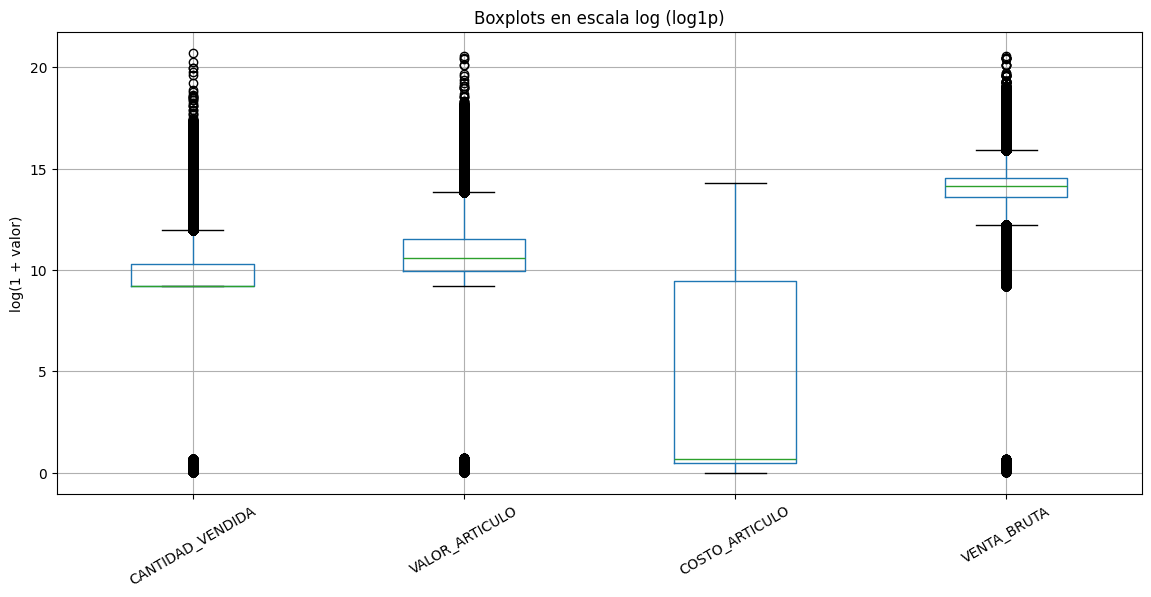

In [108]:
import numpy as np

num_cols = ["CANTIDAD_VENDIDA", "VALOR_ARTICULO", "COSTO_ARTICULO", "VENTA_BRUTA"]
num_cols = [c for c in num_cols if c in df_included.columns]

plt.figure(figsize=(14,6))
df_included[num_cols].apply(np.log1p).boxplot()
plt.title("Boxplots en escala log (log1p)")
plt.xticks(rotation=30)
plt.ylabel("log(1 + valor)")
plt.show()


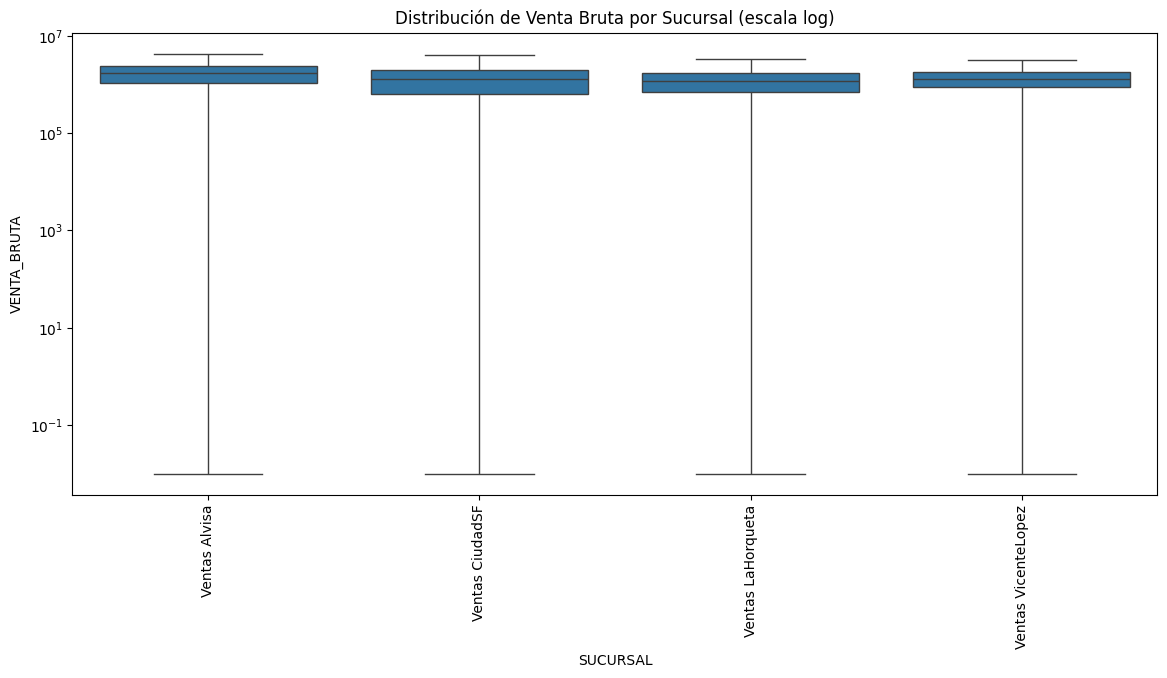

In [109]:
plt.figure(figsize=(14,6))
sns.boxplot(x="SUCURSAL", y="VENTA_BRUTA", data=df_included, showfliers=False)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Distribución de Venta Bruta por Sucursal (escala log)")
plt.show()


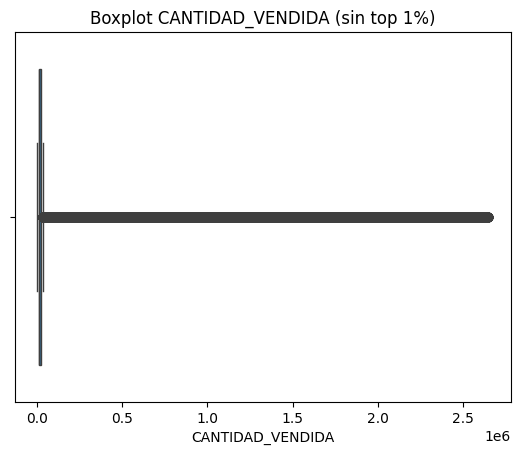

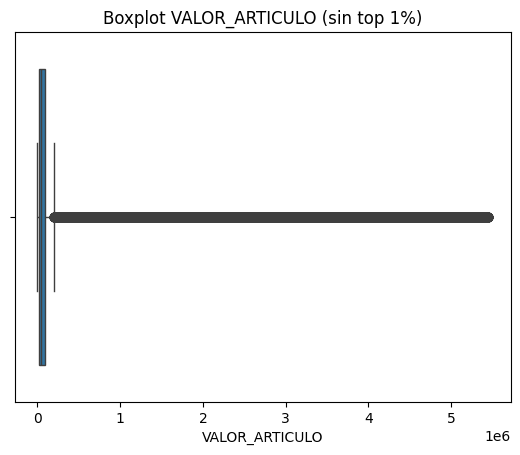

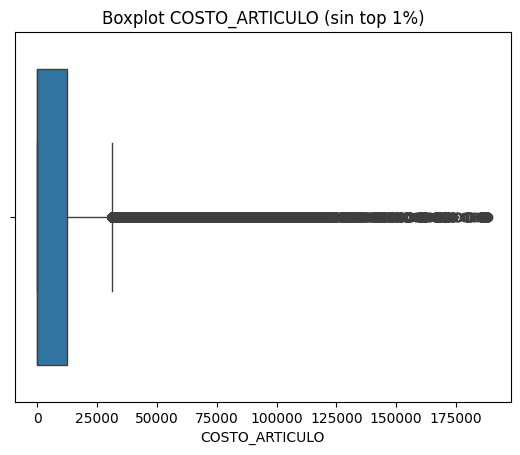

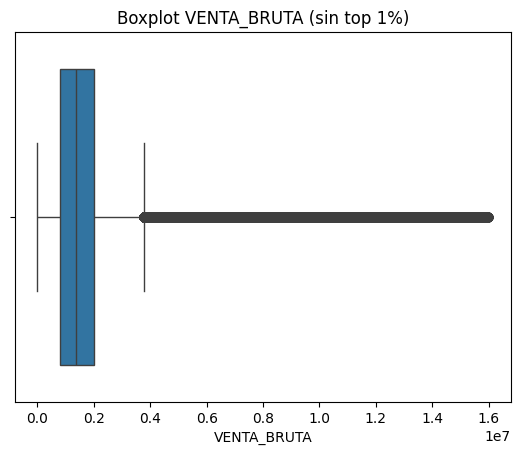

In [110]:
for col in ["CANTIDAD_VENDIDA","VALOR_ARTICULO","COSTO_ARTICULO","VENTA_BRUTA"]:
    q99 = df_included[col].quantile(0.99)
    sns.boxplot(x=df_included[col][df_included[col] < q99])
    plt.title(f"Boxplot {col} (sin top 1%)")
    plt.show()


In [113]:
# =========================================
# Conversión ARS -> USD por cierre mensual
# =========================================
import os, time, json, requests
import pandas as pd
import numpy as np
from pathlib import Path

FX_CACHE = Path("data/external/fx_monthly_cache.csv")   # cache local
FX_SERIE_ID = "168.1_T_CAMBIOR_D_0_0_26"                # BCRA: tipo de cambio vendedor (diario)
FX_URL = (
    "https://apis.datos.gob.ar/series/api/series"
    f"?ids={FX_SERIE_ID}"
    "&collapse=month&collapse_aggregation=end_of_period"
    "&start_date={start}-01{end_part}"
    "&format=json"
)

def fetch_fx_monthly(start="2020-01", end=None, retries=3, pause=2) -> pd.DataFrame:
    """Baja tipo de cambio de cierre mensual y devuelve DataFrame con Periodo (YYYY-MM) y fx_cierre."""
    end_part = f"&end_date={end}-01" if end else ""
    url = FX_URL.format(start=start, end_part=end_part)

    last_err = None
    for i in range(retries):
        try:
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            js = r.json()
            data = js["data"]
            fx = pd.DataFrame(data, columns=["fecha", "fx_cierre"])
            fx["fecha"] = pd.to_datetime(fx["fecha"])
            fx["Periodo"] = fx["fecha"].dt.to_period("M").astype(str)
            fx = fx[["Periodo", "fx_cierre"]].sort_values("Periodo").drop_duplicates("Periodo", keep="last")
            # validaciones simples
            if fx.empty:
                raise ValueError("API devolvió vacío.")
            if (fx["fx_cierre"] <= 0).any():
                raise ValueError("Valores de fx <= 0.")
            return fx
        except Exception as e:
            last_err = e
            time.sleep(pause)
    # si falló, re-lanzar error
    raise RuntimeError(f"Fallo al obtener FX mensual: {last_err}")

def get_fx_monthly(start, end) -> pd.DataFrame:
    """Intenta leer cache; si no existe/está incompleto, baja de API y actualiza cache."""
    need_fetch = True
    if FX_CACHE.exists():
        try:
            fx_cached = pd.read_csv(FX_CACHE, dtype={"Periodo":"string"})
            if not fx_cached.empty:
                # si cache cubre el rango, úsalo; si no, refresca
                pmin, pmax = fx_cached["Periodo"].min(), fx_cached["Periodo"].max()
                if (pmin <= start) and (end is None or pmax >= end):
                    need_fetch = False
                    fx = fx_cached.copy()
                else:
                    need_fetch = True
        except Exception:
            need_fetch = True

    if need_fetch:
        fx = fetch_fx_monthly(start=start, end=end)
        FX_CACHE.parent.mkdir(parents=True, exist_ok=True)
        fx.to_csv(FX_CACHE, index=False)

    # dtype seguro
    fx["Periodo"] = fx["Periodo"].astype(str)
    fx["fx_cierre"] = pd.to_numeric(fx["fx_cierre"], errors="coerce").astype("float64")
    return fx

def aplicar_fx_a_df(df_included: pd.DataFrame, fx_df: pd.DataFrame) -> pd.DataFrame:
    """Agrega Periodo, une FX y calcula VENTAS_USD y COSTOS_USD."""
    df = df_included.copy()

    # 1) Periodo desde FECHA
    if "FECHA" not in df.columns:
        raise KeyError("FECHA no está en el DataFrame para construir el período.")
    if df["FECHA"].dtype.kind != "M":
        df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
    df["Periodo"] = df["FECHA"].dt.to_period("M").astype(str)

    # 2) Unión con FX
    df = df.merge(fx_df, on="Periodo", how="left", validate="m:1")

    # 3) Checks de cobertura FX
    faltantes = df["Periodo"][df["fx_cierre"].isna()].unique()
    if len(faltantes):
        print("⚠️ Periodos sin fx_cierre:", sorted(faltantes.tolist()))

    # 4) Cálculos USD (suponiendo que ya normalizaste VALOR/COSTO/CANTIDAD a float64)
    if not {"VALOR_ARTICULO","COSTO_ARTICULO","CANTIDAD_VENDIDA"}.issubset(df.columns):
        raise KeyError("Faltan columnas para métricas: VALOR_ARTICULO/COSTO_ARTICULO/CANTIDAD_VENDIDA.")

    df["VENTAS_ARS"] = (df["VALOR_ARTICULO"] * df["CANTIDAD_VENDIDA"]).astype("float64")
    df["COSTOS_ARS"] = (df["COSTO_ARTICULO"] * df["CANTIDAD_VENDIDA"]).astype("float64")
    df["MARGEN_ARS"] = (df["VENTAS_ARS"] - df["COSTOS_ARS"]).astype("float64")

    df["VENTAS_USD"] = (df["VENTAS_ARS"] / df["fx_cierre"]).astype("float64")
    df["COSTOS_USD"] = (df["COSTOS_ARS"] / df["fx_cierre"]).astype("float64")
    df["MARGEN_USD"] = (df["MARGEN_ARS"] / df["fx_cierre"]).astype("float64")

    return df

# ======================
# USO
# ======================
# arma el rango a partir del propio df_included
pmin = pd.to_datetime(df_included["FECHA"]).dt.to_period("M").astype(str).min()
pmax = pd.to_datetime(df_included["FECHA"]).dt.to_period("M").astype(str).max()

fx_df = get_fx_monthly(start=pmin, end=pmax)

print("FX cargado. Rango:", fx_df["Periodo"].min(), "->", fx_df["Periodo"].max(),
      "| filas:", len(fx_df))

df_usd = aplicar_fx_a_df(df_included, fx_df)

# chequeo rápido
print("\nSample columnas y dtypes:")
print(df_usd[["Periodo","fx_cierre","VENTAS_ARS","VENTAS_USD","COSTOS_ARS","COSTOS_USD","MARGEN_USD"]].head())
print("\nPeriodos sin FX:", df_usd["fx_cierre"].isna().sum())


FX cargado. Rango: 2024-01 -> 2024-07 | filas: 7

Sample columnas y dtypes:
   Periodo  fx_cierre         VENTAS_ARS     VENTAS_USD        COSTOS_ARS  \
0  2024-01     845.50          21,218.66          25.10              0.90   
1  2024-01     845.50 585,000,000,000.00 691,898,285.04 10,650,000,000.00   
2  2024-01     845.50          18,000.00          21.29          2,880.00   
3  2024-01     845.50     450,000,000.00     532,229.45          7,260.00   
4  2024-01     845.50   1,300,000,000.00   1,537,551.74         16,460.00   

     COSTOS_USD     MARGEN_USD  
0          0.00          25.09  
1 12,596,096.98 679,302,188.05  
2          3.41          17.88  
3          8.59     532,220.86  
4         19.47   1,537,532.28  

Periodos sin FX: 0


In [ ]:
# =========================
# 2.- Conversión a USD (BCRA cierre mensual, usando JSON)
# =========================
import requests
import pandas as pd
import numpy as np

# 1) Periodo YYYY-MM desde FECHA (trabajamos sobre copia)
df = df_included.copy()
df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")
df["Periodo"] = df["FECHA"].dt.to_period("M").astype(str)

# Rango a pedir a la API
if df["FECHA"].notna().any():
    start = df["FECHA"].min().strftime("%Y-%m")
    end   = df["FECHA"].max().strftime("%Y-%m")
else:
    start, end = "2016-01", None

# 2) Descarga FX desde API (JSON)
base = "https://apis.datos.gob.ar/series/api/series"
params = {
    "ids": "168.1_T_CAMBIOR_D_0_0_26",   # Tipo de cambio vendedor BNA
    "collapse": "month",
    "collapse_aggregation": "end_of_period",
    "start_date": f"{start}-01",
    "format": "json",
}
if end:
    params["end_date"] = f"{end}-01"

r = requests.get(base, params=params, timeout=30)
r.raise_for_status()  # lanza error si falla
js = r.json()

fx = pd.DataFrame(js["data"], columns=["fecha","fx_cierre"])
fx["fecha"] = pd.to_datetime(fx["fecha"], errors="coerce")
fx["Periodo"] = fx["fecha"].dt.to_period("M").astype(str)
fx["fx_cierre"] = pd.to_numeric(fx["fx_cierre"], errors="coerce").astype("float64")

fx = (fx.loc[fx["fx_cierre"] > 0, ["Periodo","fx_cierre"]]
        .dropna()
        .drop_duplicates("Periodo", keep="last")
        .sort_values("Periodo"))

# 3) Merge + conversión
df_usd = df.merge(fx, on="Periodo", how="left", validate="m:1")

# Si no tienes VENTA_BRUTA confiable, cambia esta línea a VALOR_ARTICULO * CANTIDAD_VENDIDA
df_usd["VENTAS_ARS"] = pd.to_numeric(df_usd["VENTA_BRUTA"], errors="coerce").astype("float64")
df_usd["COSTOS_ARS"] = (df_usd["COSTO_ARTICULO"] * df_usd["CANTIDAD_VENDIDA"]).astype("float64")
df_usd["MARGEN_ARS"] = (df_usd["VENTAS_ARS"] - df_usd["COSTOS_ARS"]).astype("float64")

fx_ok = df_usd["fx_cierre"].replace({0.0: np.nan})
df_usd["VENTAS_USD"] = np.where(fx_ok.notna(), df_usd["VENTAS_ARS"] / fx_ok, np.nan).astype("float64")
df_usd["COSTOS_USD"] = np.where(fx_ok.notna(), df_usd["COSTOS_ARS"] / fx_ok, np.nan).astype("float64")
df_usd["MARGEN_USD"] = np.where(fx_ok.notna(), df_usd["MARGEN_ARS"] / fx_ok, np.nan).astype("float64")

# 4) Flags de control
df_usd["flag_fx_missing"] = df_usd["fx_cierre"].isna()
df_usd["flag_div_cero"]   = ~np.isfinite(df_usd["VENTAS_USD"]) | ~np.isfinite(df_usd["COSTOS_USD"])

# 5) Reporte breve
print("FX faltante (filas sin match de período):", int(df_usd["flag_fx_missing"].sum()))
print("Rango FX disponible:", fx["Periodo"].min(), "→", fx["Periodo"].max(), "| filas FX:", len(fx))

faltantes = (
    df_usd.loc[df_usd["flag_fx_missing"], "Periodo"]
          .value_counts()
          .sort_index()
)
if not faltantes.empty:
    print("\nPeríodos sin FX y cantidad de filas afectadas:")
    print(faltantes.to_string())

print(
    df_usd[["Periodo","fx_cierre","VENTAS_ARS","VENTAS_USD",
            "COSTOS_ARS","COSTOS_USD","MARGEN_USD"]].head(10)
)


FX faltante (filas sin match de período): 0
Rango FX disponible: 2024-01 → 2024-07 | filas FX: 7
   Periodo  fx_cierre   VENTAS_ARS  VENTAS_USD        COSTOS_ARS  \
0  2024-01     845.50 3,246,100.00    3,839.27              0.90   
1  2024-01     845.50 2,450,200.00    2,897.93 10,650,000,000.00   
2  2024-01     845.50 1,657,000.00    1,959.79          2,880.00   
3  2024-01     845.50 1,657,000.00    1,959.79          7,260.00   
4  2024-01     845.50 1,657,000.00    1,959.79         16,460.00   
5  2024-01     845.50 1,657,000.00    1,959.79         47,500.00   
6  2024-01     845.50 1,657,000.00    1,959.79         59,280.00   
7  2024-01     845.50 1,657,000.00    1,959.79          5,070.00   
8  2024-01     845.50 1,657,000.00    1,959.79         17,220.00   
9  2024-01     845.50 1,657,000.00    1,959.79         24,690.00   

     COSTOS_USD     MARGEN_USD  
0          0.00       3,839.27  
1 12,596,096.98 -12,593,199.05  
2          3.41       1,956.38  
3          8.59       

In [117]:

#3.- =========================
# KPIs agregados en USD
# =========================

# Trabajamos sobre df_usd (ya creado en el bloque anterior)
dfk = df_usd.loc[~df_usd["flag_fx_missing"]].copy()

# 1) Agrupación por Periodo y Sucursal
kpi_suc = (
    dfk.groupby(["Periodo","SUCURSAL"], dropna=False)
       .agg(
           ventas_usd=("VENTAS_USD","sum"),
           costos_usd=("COSTOS_USD","sum"),
           margen_usd=("MARGEN_USD","sum"),
           tickets=("NUMERO_TICKET","nunique"),
           items=("ID_ARTICULO","count"),
           sku_unicos=("ID_ARTICULO","nunique")
       )
       .reset_index()
       .sort_values(["Periodo","SUCURSAL"])
)

# 2) Margen % y ticket promedio
kpi_suc["margen_pct"] = (kpi_suc["margen_usd"] / kpi_suc["ventas_usd"]).replace([np.inf,-np.inf], np.nan)
kpi_suc["ticket_prom_usd"] = (kpi_suc["ventas_usd"] / kpi_suc["tickets"]).replace([np.inf,-np.inf], np.nan)

print("\n=== KPIs por Periodo x Sucursal ===")
print(kpi_suc.head(20))

# 3) (Opcional) por Periodo y Producto (ojo volumen)
if {"ID_ARTICULO","DESC_ARTICULO"}.issubset(dfk.columns):
    kpi_prod = (
        dfk.groupby(["Periodo","ID_ARTICULO","DESC_ARTICULO"], dropna=False)
           .agg(ventas_usd=("VENTAS_USD","sum"),
                costos_usd=("COSTOS_USD","sum"),
                margen_usd=("MARGEN_USD","sum"),
                qty=("CANTIDAD_VENDIDA","sum"))
           .reset_index()
           .sort_values(["Periodo","ventas_usd"], ascending=[True, False])
    )
    print("\n=== TOP productos por Periodo (ventas USD) ===")
    print(kpi_prod.groupby("Periodo").head(10))
else:
    kpi_prod = None

# 4) (Opcional) pivote mensual por sucursal para visual rápido
pivot_ventas = kpi_suc.pivot(index="Periodo", columns="SUCURSAL", values="ventas_usd")
pivot_margen = kpi_suc.pivot(index="Periodo", columns="SUCURSAL", values="margen_usd")
print("\nPivot ventas (USD):")
print(pivot_ventas.tail(12))

# 5) (Opcional) guardar a CSV
# kpi_suc.to_csv("kpi_sucursal_mensual_usd.csv", index=False)
# if kpi_prod is not None:
#     kpi_prod.to_csv("kpi_producto_mensual_usd.csv", index=False)



=== KPIs por Periodo x Sucursal ===
    Periodo             SUCURSAL     ventas_usd        costos_usd  \
0   2024-01        Ventas Alvisa  90,581,943.82 18,332,568,626.46   
1   2024-01      Ventas CiudadSF  68,570,619.40 26,754,708,512.04   
2   2024-01    Ventas LaHorqueta  59,369,188.89 37,453,928,675.85   
3   2024-01  Ventas VicenteLopez  47,969,820.94 11,848,789,333.92   
4   2024-02        Ventas Alvisa  77,263,230.66 20,179,383,466.66   
5   2024-02      Ventas CiudadSF  68,222,190.83 25,677,224,582.13   
6   2024-02    Ventas LaHorqueta  61,972,215.69 44,016,959,678.42   
7   2024-02  Ventas VicenteLopez  45,163,208.37 13,112,334,750.75   
8   2024-03        Ventas Alvisa  92,850,010.50 22,091,458,011.36   
9   2024-03      Ventas CiudadSF  71,040,205.37  9,369,487,291.17   
10  2024-03    Ventas LaHorqueta  67,346,341.90 50,607,101,325.98   
11  2024-03  Ventas VicenteLopez  44,901,375.11 11,135,155,447.60   
12  2024-04        Ventas Alvisa  94,407,622.32 19,889,857,732.10 

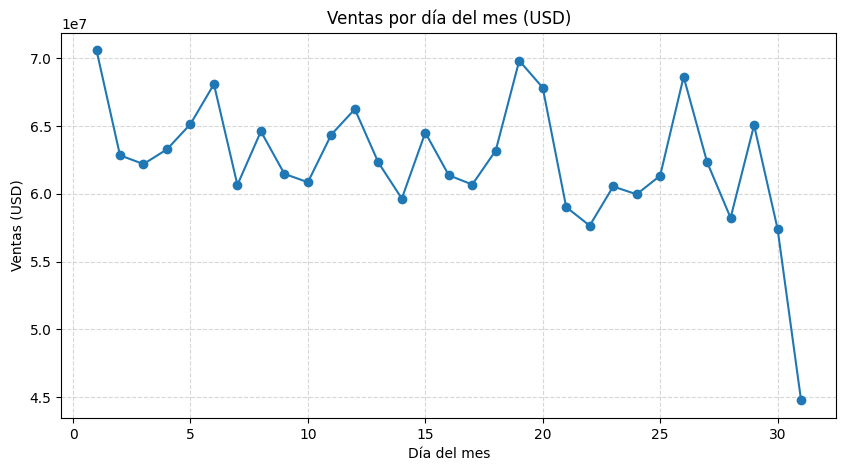

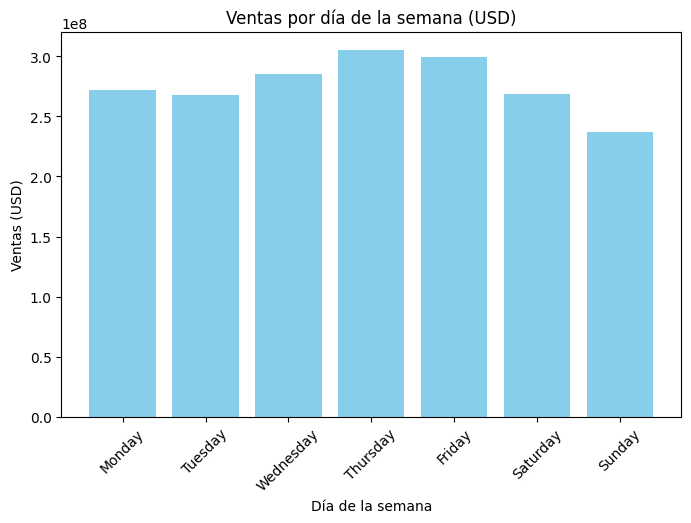

=== Correlación de cada sucursal con el patrón global (semana) ===


SUCURSAL
Ventas LaHorqueta     0.61
Ventas Alvisa         0.79
Ventas CiudadSF       0.79
Ventas VicenteLopez   0.82
dtype: float64

Sucursales que no siguen el patrón global: []


In [118]:
# =========================
# Estacionalidad de Ventas
# =========================
import matplotlib.pyplot as plt

df = df_usd.copy()

# ======================================
# 1. Preparar columnas temporales
# ======================================
df["dia_mes"] = df["FECHA"].dt.day
df["dia_semana"] = df["FECHA"].dt.dayofweek      # 0=Lunes … 6=Domingo
df["nombre_semana"] = df["FECHA"].dt.day_name()  # en inglés por defecto

# Si quieres en español y tu sistema lo soporta:
# df["nombre_semana"] = df["FECHA"].dt.day_name(locale="es_ES")

# ======================================
# 2. Estacionalidad intra-mes (día del mes)
# ======================================
ventas_dia_mes = (
    df.groupby("dia_mes", as_index=False)
      .agg({"VENTAS_USD":"sum"})
)

plt.figure(figsize=(10,5))
plt.plot(ventas_dia_mes["dia_mes"], ventas_dia_mes["VENTAS_USD"], marker="o")
plt.title("Ventas por día del mes (USD)")
plt.xlabel("Día del mes")
plt.ylabel("Ventas (USD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ======================================
# 3. Estacionalidad semanal (día de la semana)
# ======================================
ventas_dia_semana = (
    df.groupby("nombre_semana", as_index=False)
      .agg({"VENTAS_USD":"sum"})
)

# Ordenar de lunes a domingo
orden_dias = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
ventas_dia_semana["nombre_semana"] = pd.Categorical(
    ventas_dia_semana["nombre_semana"], categories=orden_dias, ordered=True
)
ventas_dia_semana = ventas_dia_semana.sort_values("nombre_semana")

plt.figure(figsize=(8,5))
plt.bar(ventas_dia_semana["nombre_semana"], ventas_dia_semana["VENTAS_USD"], color="skyblue")
plt.title("Ventas por día de la semana (USD)")
plt.xlabel("Día de la semana")
plt.ylabel("Ventas (USD)")
plt.xticks(rotation=45)
plt.show()

# ======================================
# 4. Detección de sucursales atípicas
# ======================================

# Perfil global (proporción de ventas por día de semana)
perfil_global = (
    df.groupby("dia_semana")["VENTAS_USD"].sum()
    .sort_index()
)
perfil_global = perfil_global / perfil_global.sum()

# Perfil normalizado por sucursal
perfiles = (
    df.groupby(["SUCURSAL","dia_semana"])["VENTAS_USD"].sum()
      .groupby(level=0).apply(lambda x: x / x.sum())
)

# Correlación Spearman de cada sucursal vs perfil global
corrs = perfiles.unstack(0).corrwith(perfil_global, axis=0, method="spearman")
corrs = corrs.sort_values()

print("=== Correlación de cada sucursal con el patrón global (semana) ===")
display(corrs)

# Atípicas: correlación < 0.5 (ajustable)
sucursales_atipicas = corrs[corrs < 0.5].index.tolist()
print("Sucursales que no siguen el patrón global:", sucursales_atipicas)
